In [1]:
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import os
EXPORT_FOLDER = "./data/"

In [2]:
# url = "https://www.millenaire3.com/ressources/2023/changer-les-comportements-revue-et-enseignements-des-actions-metropolitaines"
# url2 = "https://www.millenaire3.com/ressources/2023/agir-sur-les-modes-de-vie-une-nouvelle-grille-d-analyse"
# url3 = "https://www.millenaire3.com/dossiers/2022/resilience-quelles-articulations-entre-acteurs-publics-et-initiatives-du-territoire"
# url4 = "https://www.millenaire3.com/dossiers/2022/resilience-quelles-articulations-entre-acteurs-publics-et-initiatives-du-territoire/institut-transitions-notre-but-c-est-de-former-ceux-qui-peuvent-agir-des-aujourd-hui"
# url5 = "https://www.millenaire3.com/dossiers/2022/resilience-quelles-articulations-entre-acteurs-publics-et-initiatives-du-territoire/les-alchimistes-lyon-alimentation-gaspillage-compostage-aucun-de-ces-sujets-ne-laisse-indifferent"
# url6 = "https://www.millenaire3.com/ressources/2023/crise-ecologique-le-metabolisme-de-l-economie-au-caeur-des-enjeux"
# url7 = "https://www.millenaire3.com/dossiers/2015/la-soierie-lyonnaise-entre-tradition-et-innovation-archives/la-soie-a-lyon-une-initiative-du-pouvoir-royal"
# urls = [url, url2, url3, url4, url5, url6, url7]

In [3]:
def get_metadata(soup, type, url, mult_items, errors):

    mult_items[url] = {"auteurs" : [], "tags" : [], "liens" : []}

    #TAGS
    tags_liste = soup.find_all("ul", {"class": "list-inline keywords"})
    tags = []
    for tag in tags_liste:
        a = tag.find_all("a")
        for tag in a:
            if re.search("tag", tag["href"]) != None:
                tags += tag.contents
    if len(tags) > 0:
        mult_items[url]["tags"] = tags
    else:
        mult_items[url]["tags"] = "NA"

    #AUTHORS
    if type == "Interview":
        liste = soup.find_all("ul", {"class": "list-inline keywords"})
        authors = []
        for elem in liste:
            a = elem.find_all("a")
            for author in a:
                if re.search("auteurs", author["href"]) != None:
                    authors.append(author.contents[0].strip())
    else:
        auth = soup.find_all("span", {"class" : "author-name"})
        authors = []
        for author in auth:
            author = repr(author.text).replace("\\xa0", " ").replace("\\t", "").replace("\\n", "").replace("'", "")
            if author not in authors:
                authors.append(author)
    if len(authors) > 0:
        mult_items[url]["auteurs"] = authors
    else:
        mult_items[url]["auteurs"] = "NA"
        
    #Liens
    page_links = soup.find_all("h3", {"class" : "h3 uppercase"})
    links = []
    for link in page_links:
        links.append("https://www.millenaire3.com"+link.a["href"])
    if len(links) > 0:
        mult_items[url]["liens"] = links
    else:
        mult_items[url]["liens"] = "NA"
    
    return(mult_items, errors)

In [4]:
def get_article_info(soup, type, url, container, errors):

    #RESUME
    if type == "Dossier":
        resume = soup.find("div", {"class" : "eztext-field"})
    elif type == "Interview":
        resume = soup.find("div", {"class" : "ezrichtext-field"})
    else: 
        resume = soup.find("div", {"class" : "eztext-field"})
    if len(resume) > 0:
        container["RESUME"].append(resume.text)
    else:
        errors["RESUME"].append(url)
        container["RESUME"].append("NA")

    #ARTICLE
    if type != "Interview":
        try:
            article = soup.find("div",  {"class" : "ezrichtext-field"}).text
        except:
            article = ""
    else:
        lines = soup.find_all("div", {"class" : "interview-item"})
        if len(lines) == 0:
            art = soup.find_all("div",  {"class" : "ezrichtext-field"})
            for info in art:
                if info != resume.text:
                    article = info.text
        else:
            article = ""
            for i, line in enumerate(lines):
                article += line.find("p", {"class" : "over-under-line"}).text + " "
                temp = line.find_all("div", {"class" : "ezrichtext-field"})
                for info in temp:
                    article += info.find("p").text
    if len(article) > 0:
        container["ARTICLE"].append(article.replace("\n", " "))
    else:
        errors["ARTICLE"].append(url)
        container["ARTICLE"].append("NA")

    #TITRE
    titre = soup.find("h1", {"class": "uppercase h1-special"}).contents[0]
    titre = titre.replace("\n", "").replace("\t", "").strip()
    if len(titre) > 0:
        container["TITRE"].append(titre)
    else:
        errors["TITRE"].append(url)
        container["TITRE"].append("NA")
        
    #ID - in db
    try:
        ID = soup.find("article", {"class" : "sidebar-block-classic sidebar-block-download"})
        ID = ID.a["href"].split("/")
        ID = ID[len(ID)-1]
        container["IDinDB"].append(ID)
    except:
        container["IDinDB"].append("NA")

    #DATE
    date = soup.find("span", {"class" : "publication_date"}).text
    if len(date) > 0:
        container["DATE"].append(date)
    else:
        errors["DATE"].append(url)
        container["DATE"].append("NA")
    
    #URL
    container["URL"].append(url)
    return(container, errors)

In [5]:
def scrap_page(page, container, mult_items, errors, HTML_FOLDER, url, ONLY_MULT = False):
    
    # html = requests.get(url)
    # if(html.status_code) != 200:
    #     print(html.status_code)
    #     errors["deadlink"].append(url)
    #     return(1)
    # soup = BeautifulSoup(html.text, "html.parser")
    with open(HTML_FOLDER+page, "r", encoding="utf8") as f:
        html= f.read()
    soup = BeautifulSoup(html, "html.parser")
    
    #TYPE
    type_liste = soup.find_all("p", {"class" : re.compile("^over-under")})
    if len(type_liste) > 0:
        type = ""
        for typ in type_liste:
            if re.search("Étude|Dossier|Article|Texte|Interview", typ.text) == None:
                continue
            else:
                if re.search("Interview|Texte", typ.text) == None:
                    type = typ.text.replace("\n", "").replace("\t", "").replace(" ", "")
                elif re.search("Texte", typ.text) != None:
                    type = "Texte"
                    txt_de = typ.text.replace("\n", "").replace("\t", "")
                elif re.search("Interview", typ.text) != None:
                    type = "Interview"
                    itw_de = typ.text.replace("\n", "").replace("\t", "")
    else:
        return(1)
    if len(type) > 0:
        container["TYPE"].append(type)
    else:
        errors["TYPE"].append(url)
        return(1)
    #END TYPE

    if ONLY_MULT == True:
        get_metadata(soup, type, url, mult_items, errors)
    else:
        get_article_info(soup, type, url, container, errors)
        get_metadata(soup, type, url, mult_items, errors)

    return(container, mult_items, errors)


In [6]:
ONLY_MULT = False
HTML_FOLDER = "urls/"

with open("data/M3urls_mac.txt", "r") as f:
        uris = f.read().split("\n")

urls = os.listdir(HTML_FOLDER)
urls.sort(key = lambda x: int(x.replace(".html", "")))

container = {"URL" : [], 
                "TITRE" : [], 
                "IDinDB" : [], 
                "TYPE" : [], 
                "RESUME" : [], 
                "ARTICLE" : [],
                "DATE" : []}

mult_items = {}

errors = {
        "TITRE" : [],
        "TYPE" : [],
        "RESUME" : [],
        "ARTICLE" : [],
        "DATE" : [],
        "deadlink" : []
    }

for i, url in enumerate(urls):
    uri = uris[int(url.replace(".html", ""))]
    print(f"""\r{i}/{len(urls)} : {url}, {url.replace(".html", "")} : {uri}""", end = "")
    if re.search("/auteurs/|/tag/|partage_email|/generated_pdf|m3_search", uri) == None and len(url) > 0:
        scrap_page(url, container, mult_items, errors, HTML_FOLDER, uri, ONLY_MULT)
    else:
        pass
        #print("not an article")


for keys in container:
    print(keys, ":", len(container[keys]))


4018/6111 : 4022.html, 4022 : https://www.millenaire3.com#onglet_7060rnieres_ressourcesla-proprete-urbainent-de-la-sobriete-d-usage-a-la-sobriete-immobilieren-zes-precairesyonnaiseuees-de-brevets-et-d-innovationsaeslyon-et-turin2F12%2F2025&date_fin_mobile=&identifiers=&rubriques=

c:\Users\Alioscha\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


6110/6111 : 15559.html, 15559 : https://www.millenaire3.com/dossiers/2020/veille-m3/Veille-M3-Collapsologie-La-commune-derniere-utopie-avant-l-effondrementURL : 4766deesle-suivant-meilleure-HCCuxie-plus-decentralisecer-l-unite-de-l-agglomeration-par-l-harmonisation-des-signes-du-terries-villest-evoluer
TITRE : 4766
IDinDB : 4766
TYPE : 4766
RESUME : 4766
ARTICLE : 4766
DATE : 4766


In [7]:
for keys in container:
    print(len(container[keys]))

4766
4766
4766
4766
4766
4766
4766


In [8]:
# container["URL"].append("NA")
# container["TITRE"].append("NA")
# container["IDinDB"].append("NA")
# container["ARTICLE"].append("NA")
# container["DATE"].append("NA")
with open(EXPORT_FOLDER+"data_items.json", "w", encoding="utf8") as f:
    f.write(json.dumps(mult_items, indent=4))
tab = pd.DataFrame(container)
tab.to_csv(EXPORT_FOLDER+"data_article.csv")
tab

,URL,TITRE,IDinDB,TYPE,RESUME,ARTICLE,DATE
0,https://www.millenaire3.com/dossiers/2023/acti...,Action publique : comment penser la solidarité...,NA,Dossier,"Qu’ont en commun le dérèglement climatique, l’...",Sommaire :Protection sociale : construire une ...,06/04/2023
1,https://www.millenaire3.com/dossiers/2022/vers...,Vers une reconquête de la qualité de l’air : p...,NA,Dossier,Changer nos modes de déplacement et retrouver ...,SommaireInfographie sur les limites planétaire...,10/03/2022
2,https://www.millenaire3.com/dossiers/2022/resi...,Résilience : quelles articulations entre acteu...,NA,Dossier,"Ces dernières années, la question de la résili...","En effet, ce dossier met en avant trois postur...",12/04/2022
3,https://www.millenaire3.com/dossiers/2021/l-in...,"L’inclusion, un nouveau modèle de société ?",NA,Dossier,La notion d’inclusion a renouvelé le modèle di...,,05/03/2021
4,https://www.millenaire3.com/dossiers/2021/econ...,"Économie circulaire : au-delà du recyclage, co...",NA,Dossier,L’essor du concept d’économie circulaire fait ...,À découvrir dans ce dossier :1. Économie circu...,09/03/2021
...,...,...,...,...,...,...,...
4761,https://www.millenaire3.com/dossiers/2020/veil...,Veille M3/Collapsologie : Avec « Les Terrestre...,NA,Article,"Dans la bande dessinée « Les Terrestres », l’a...","C’était le “monde d’avant ”, quand la question...",01/02/2021
4762,https://www.millenaire3.com/dossiers/2020/veil...,Veille M3/Collapsologie : L'expo « Critical zo...,NA,Article,"« Zones critiques », une exposition initiée et...",Sortir d’une approche en silos pour mixer diff...,18/01/2021
4763,https://www.millenaire3.com/dossiers/2020/veil...,"Veille M3/Collapsologie : La collapsologie, ou...",NA,Article,Depuis la sortie en 2015 de l’essai « Comment ...,À l’instar de Bruno Latour ou Jean-Pierre Dupu...,05/01/2021
4764,https://www.millenaire3.com/dossiers/2020/veil...,Veille M3/Collapsologie : De l’effondrisme au ...,NA,Article,"Dans son dernier essai, le philosophe Achille ...","Dans Brutalisme, Achille Mbembe n’utilise pas ...",14/12/2020


In [39]:
i = 0
for URL in urls:
    if URL not in container["URL"] and URL not in errors["deadlink"] and "partage_email" not in URL and "/auteurs/" not in URL and "/tag/" not in URL:
        i += 1
        print(i, URL)

1 https://www.millenaire3.com
2 https://www.millenaire3.com/
3 https://www.millenaire3.com#content
4 https://www.millenaire3.com#main-menu
5 https://www.millenaire3.com#block-search
6 https://www.millenaire3.com/nos-flux-rss
7 https://www.millenaire3.com/societe
8 https://www.millenaire3.com/modes-d-action
9 https://www.millenaire3.com/transformation-urbaine
10 https://www.millenaire3.com/politiques-publiques
11 https://www.millenaire3.com/territoire
12 https://www.millenaire3.com/soutenabilite
13 https://www.millenaire3.com/actualites-a-la-une/le-rapport-a-la-proprete-urbaine
14 https://www.millenaire3.com/actualites-a-la-une/veille-m3-famille-du-concept-de-fraternite
15 https://www.millenaire3.com/actualites-a-la-une/le-spectacle-vivant-au-defi-de-la-jeunesse-et-du-numerique
16 https://www.millenaire3.com/actualites-a-la-une/crise-ecologique-le-metabolisme-de-l-economie-au-caeur-des-enjeux
17 https://www.millenaire3.com#carousel-example-generic
18 https://www.millenaire3.com#onglet_1

In [40]:
urls[7888]

'https://www.millenaire3.com/dossiers/Les-Cahiers-Millenaire-3-archive/Cahier-Millenaire-3-n-21-Une-agglomeration-competitive-et-rassemblee'

In [9]:
errors

{'TITRE': [],
 'TYPE': ['https://www.millenaire3.com',
  'https://www.millenaire3.com/',
  'https://www.millenaire3.com#content',
  'https://www.millenaire3.com#main-menu',
  'https://www.millenaire3.com#block-search',
  'https://www.millenaire3.com/societe',
  'https://www.millenaire3.com/modes-d-action',
  'https://www.millenaire3.com/transformation-urbaine',
  'https://www.millenaire3.com/politiques-publiques',
  'https://www.millenaire3.com/territoire',
  'https://www.millenaire3.com/soutenabilite',
  'https://www.millenaire3.com/actualites-a-la-une/le-nouveau-conseil-de-developpement-de-la-metropole-s-installe-le-22-juin',
  'https://www.millenaire3.com/actualites-a-la-une/le-dernier-m3-vient-de-sortir',
  'https://www.millenaire3.com/actualites-a-la-une/un-nouveau-millenaire3-flambant-neuf',
  'https://www.millenaire3.com/actualites-a-la-une/place-aux-nudges',
  'https://www.millenaire3.com/actualites-a-la-une/le-second-coworking-tour-dedie-aux-entreprises-a-eu-lieu-!',
  'https:

N
A
Mobilité
Climat
Transition
Innovation
Citoyenneté
Grand Lyon
Économie
Solidarité
Inclusion
Ressources
Temps
Politique de la ville
Urbanisme
Usage
Service public
Valeurs
Cadre de vie
Pauvreté
Prospective
Pensées politiques
Numérique
Biodiversité
Entreprise
Veille M3
Institution
Patrimoine
Concertation
Justice
Culture
Clivages
Cohésion sociale
Santé
Social
Insertion
Genre
Éducation
Jeunesse
Sport
Recherche
Handicap
Travail
Attractivité
Démocratie
Développement durable
Management
Data
Évaluation
Laïcité
Finance
International
Action publique
Revue M3
Personnes âgées
Sécurité
Égalité

   	Théo BATTAGLIA

Emploi
{
    "N": {
        "value": 18,
        "A": {
            "weight": 18
        }
    },
    "A": {
        "value": 18,
        "N": {
            "weight": 18
        }
    },
    "Mobilit\u00e9": {
        "value": 188,
        "Climat": {
            "weight": 6
        },
        "Transition": {
            "weight": 22
        },
        "Service public": {
            "w

{'data': [],
 'directed': False,
 'multigraph': False,
 'elements': {'nodes': [{'data': {'id': 'N', 'value': 'N', 'name': 'N'}},
   {'data': {'id': 'A', 'value': 'A', 'name': 'A'}},
   {'data': {'id': 'Mobilité', 'value': 'Mobilité', 'name': 'Mobilité'}},
   {'data': {'id': 'Climat', 'value': 'Climat', 'name': 'Climat'}},
   {'data': {'id': 'Transition', 'value': 'Transition', 'name': 'Transition'}},
   {'data': {'id': 'Innovation', 'value': 'Innovation', 'name': 'Innovation'}},
   {'data': {'id': 'Citoyenneté',
     'value': 'Citoyenneté',
     'name': 'Citoyenneté'}},
   {'data': {'id': 'Grand Lyon', 'value': 'Grand Lyon', 'name': 'Grand Lyon'}},
   {'data': {'id': 'Économie', 'value': 'Économie', 'name': 'Économie'}},
   {'data': {'id': 'Solidarité', 'value': 'Solidarité', 'name': 'Solidarité'}},
   {'data': {'id': 'Inclusion', 'value': 'Inclusion', 'name': 'Inclusion'}},
   {'data': {'id': 'Ressources', 'value': 'Ressources', 'name': 'Ressources'}},
   {'data': {'id': 'Temps', 'val

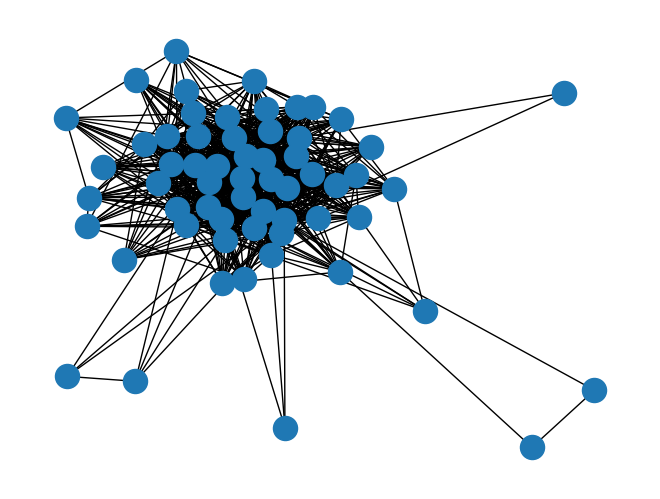

In [48]:
import networkx as nx

tag_dic = {}

for url in mult_items:
    # print(url, len(mult_items[url]["tags"]))
    for tag in mult_items[url]["tags"]:
        if tag not in tag_dic.keys():
            tag_dic[tag] = {}

for tag in tag_dic.keys():
    tag_dic[tag]["value"] = 0
    for url in mult_items:
        if tag in mult_items[url]["tags"]:
            tag_dic[tag]["value"] += 1
            for t in mult_items[url]["tags"]:
                if t != tag and t not in tag_dic[tag].keys():
                    tag_dic[tag][t] = {"weight" : 1}
                elif t != tag and t in tag_dic[tag].keys():
                    tag_dic[tag][t]["weight"] += 1


G = nx.Graph()

for url in mult_items:
    for tag in mult_items[url]["tags"]:
        if tag not in G.nodes():
            G.add_node(tag, value = 1)
        elif tag in G.nodes():
            G

for node in G.nodes:
    for url in mult_items:
        if node in mult_items[url]["tags"]:
            for tag in mult_items[url]["tags"]:
                if t != tag and not G.has_edge(tag, t):
                    G.add_edge(tag, t, weight = 1)
                elif t != tag and G.has_edge(tag, t):
                    tag_dic[tag][t]["weight"] += 1

g = nx.Graph(tag_dic)
nx.draw(g)
nx.cytoscape_data(g, name = "net_tags.json")
